In [65]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import quad

## Defining the integrand function and the integral function

In [81]:
#integrand = lambda x: np.sin(x)/x
def integrand(x):
    if isinstance(x,torch.Tensor):
        return torch.sin(x)/x
    else:
        return np.sin(x)/x
        
def integral(xmin,xmax):
    result,_ = quad(integrand,xmin,xmax)
    return result

## Constructing the network

In [99]:
def x_batcher(xmin,xmax,N):
    # Prepares a batch of x values in the [xmin,xmax] interval and the corresponding values of the integrand

    x_batch = xmin + (xmax-xmin)*torch.rand(N,1,requires_grad=True)
    y_batch = integrand(x_batch)
    return x_batch, y_batch

class NNIntegrate(nn.Module):
    # NN for the integration
    def __init__(self, hidden_dim, hidden_size, activation):
        '''
        hidden_dim: int
            The dimension of the hidden layer(s)
        hidden_size: int
            The number of hidden layers
        activation: nn Class
            Activation function class from torch.nn
        '''
        super().__init__()

        layers = []
        layers.append(nn.Linear(1,hidden_dim))
        layers.append(activation)

        for i in range(hidden_size):
            layers.append(nn.Linear(hidden_dim,hidden_dim))
            layers.append(activation)

        layers.append(nn.Linear(hidden_dim,1))

        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        
        return self.network(x)
        

## Training the model

In [100]:
# Hyperparameters
hidden_dim = 16 # dimension of the hidden layer
hidden_size = 1  # Number of hidden layers

xmin = 0.0
xmax = 10.0
N_points = 100

learning_rate = 0.01
num_epochs = 2000

x_batch, y_batch = x_batcher(xmin,xmax,N_points)

# Instantiate the model, define the loss function, optimizer and scheduler
model = NNIntegrate(hidden_dim,hidden_size,nn.Tanh())
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.8)

loss_arr = []
model.train()

start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    
    prediction = model(x_batch)
    output_deriv = torch.autograd.grad(prediction, x_batch, torch.ones_like(prediction),create_graph=True)[0] # derivative
    loss = criterion(output_deriv,y_batch)
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True) # since the graph is already created
    optimizer.step()
    scheduler.step()
    loss_arr.append(loss.detach().numpy())

    if epoch % (num_epochs // 10) == 0:
        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}, lr: {optimizer.param_groups[0]["lr"]}')

print()
end_time = time.time()

train_time = end_time - start_time
print(f"Training time: {train_time} seconds")

Epoch 0/2000, Loss: 0.15558595955371857, lr: 0.01
Epoch 200/2000, Loss: 0.0013295502867549658, lr: 0.008
Epoch 400/2000, Loss: 0.0004958291538059711, lr: 0.0064
Epoch 600/2000, Loss: 2.874312940548407e-06, lr: 0.00512
Epoch 800/2000, Loss: 5.626191068586195e-07, lr: 0.004096000000000001
Epoch 1000/2000, Loss: 3.1048031701175205e-07, lr: 0.0032768000000000007
Epoch 1200/2000, Loss: 2.3345620547843282e-07, lr: 0.002621440000000001
Epoch 1400/2000, Loss: 1.9791059457929805e-07, lr: 0.002097152000000001
Epoch 1600/2000, Loss: 1.7617010428239155e-07, lr: 0.001677721600000001
Epoch 1800/2000, Loss: 1.6076749886906327e-07, lr: 0.0013421772800000008

Training time: 2.2081186771392822 seconds


Plot the evolution of loss function

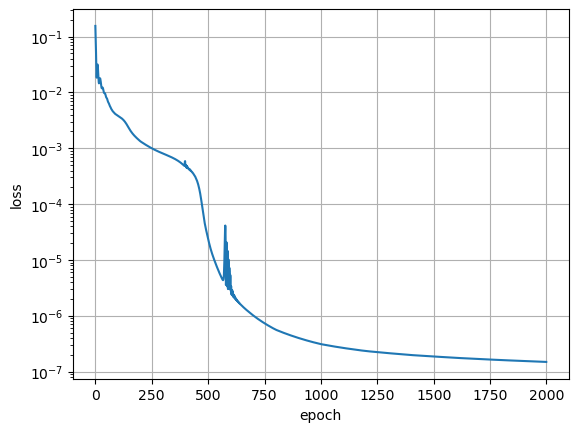

In [101]:
plt.figure()
plt.semilogy(range(num_epochs),loss_arr)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## Evaluate the model and compare the results

In [102]:
# Should be within the limits in which the model was trained
x_min = 0.0
x_max = 9.0

# Neural network (NN) result
model.eval()
start_time_NN = time.time()
result_NN = (model(torch.tensor([x_max])) - model(torch.tensor([x_min]))).detach().numpy().item()
end_time_NN = time.time()

NN_time = end_time_NN - start_time_NN

# Numerical integration (NI) result
start_time_NI = time.time()
result_NI = integral(x_min,x_max)
end_time_NI = time.time()

NI_time = end_time_NI - start_time_NI

print(f"NN result: {result_NN}")
print(f"NI result: {result_NI}")
print(f"NN timing: {NN_time} s, NI timing: {NI_time} s")

NN result: 1.6657711267471313
NI result: 1.6650400758296027
NN timing: 0.0021915435791015625 s, NI timing: 0.0002243518829345703 s
